<a href="https://colab.research.google.com/github/EvgenEgorov/transcriptomics_msu_HW/blob/main/HW13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 13. Дифференцировка клеток. Определение генов, меняющих свою экспрессию по ходу псевдовремени

В этом семинаре мы будем работать с scRNA-seq проходящей дифференцировку поджелудочной железы и применим для анализа алгоритмы RNA velocity и CellRank, после чего самостоятельно идентифицируем гены, меняющие свою экспрессию по ходу псевдовремени, с помощью генерализованных аддитивных моделей (GAM).

In [ ]:
# Install packages
!pip install scikit-misc scanpy cellrank scvelo python-igraph palantir
!pip install rpy2==3.5.1

# Restart runtime
# (it is needed to update Matplotlib version)
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 18.3 MB/s 
     |████████████████████████████████| 2.0 MB 54.7 MB/s 
     |████████████████████████████████| 250 kB 62.1 MB/s 
     |████████████████████████████████| 219 kB 36.9 MB/s 
     |████████████████████████████████| 88 kB 5.3 MB/s 
     |████████████████████████████████| 96 kB 1.7 MB/s 
     |████████████████████████████████| 9.4 MB 22.0 MB/s 
     |████████████████████████████████| 965 kB 37.4 MB/s 
     |████████████████████████████████| 295 kB 46.0 MB/s 
     |████████████████████████████████| 1.1 MB 60.7 MB/s 
     |████████████████████████████████| 1.8 MB 25.9 MB/s 
     |████████████████████████████████| 68 kB 1.8 MB/s 
     |████████████████████████████████| 4.8 MB 54.0 MB/s 
     |████████████████████████████████| 133 kB 10.3 MB/s 
     |████████████████████████████████| 3.3 MB 67.9 MB/s 
     |███████████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 201 kB 35.2 MB/s 
  Created wheel for rpy2: filename=rpy2-3.5.1-cp38-cp38-linux_x86_64.whl size=310204 sha256=e8f3cbb0c49b2038c55c8b6b9b3fda0fd3cfa1a58a97d1d75f36c16ab3cf8716
  Stored in directory: /root/.cache/pip/wheels/6b/40/7d/f63e87fd83e8b99ee837c8e3489081c4b3489134bc520235ed
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


In [1]:
%load_ext rpy2.ipython

!Rscript -e 'install.packages("mgcv")'
!Rscript -e 'install.packages("plyr")'
!Rscript -e 'install.packages("dplyr")'
!Rscript -e 'install.packages("ggplot2")'
!Rscript -e 'install.packages("tidymv")'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/mgcv_1.8-41.tar.gz'
Content type 'application/x-gzip' length 1072476 bytes (1.0 MB)
downloaded 1.0 MB

* installing *source* package ‘mgcv’ ...
** package ‘mgcv’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
gcc -I"/usr/share/R/include" -DNDEBUG     -fopenmp -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-ZLat0n/r-base-4.2.2.20221110=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c coxph.c -o coxph.o
gcc -I"/usr/share/R/include" -DNDEBUG     -fopenmp -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-ZLat0n/r-base-4.2.2.20221110=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c davies.c -o davies.o
gcc -I"/usr/share/R/include" -DNDEBUG     -fopenmp -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-ZLat0n/r-base-4.2.2.20221110=. -fstack-prot

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr
import palantir
%matplotlib inline

# Настроим параметры изображений и степень подробности сообщений 
sc.set_figure_params(figsize=(7, 5))
sns.set_theme(style='whitegrid')
cr.settings.verbosity = 2

# Hide some of the warnings
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

## Pseudotime and differentiation potential with Palantir

Сперва загрузим наш датасет. Он доступен в виде готового объекта AnnData в библиотеке CellRank.

In [3]:
adata = cr.datasets.pancreas()
adata

  0%|          | 0.00/33.5M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

На этом датасете уже получен UMAP и размечены кластеры

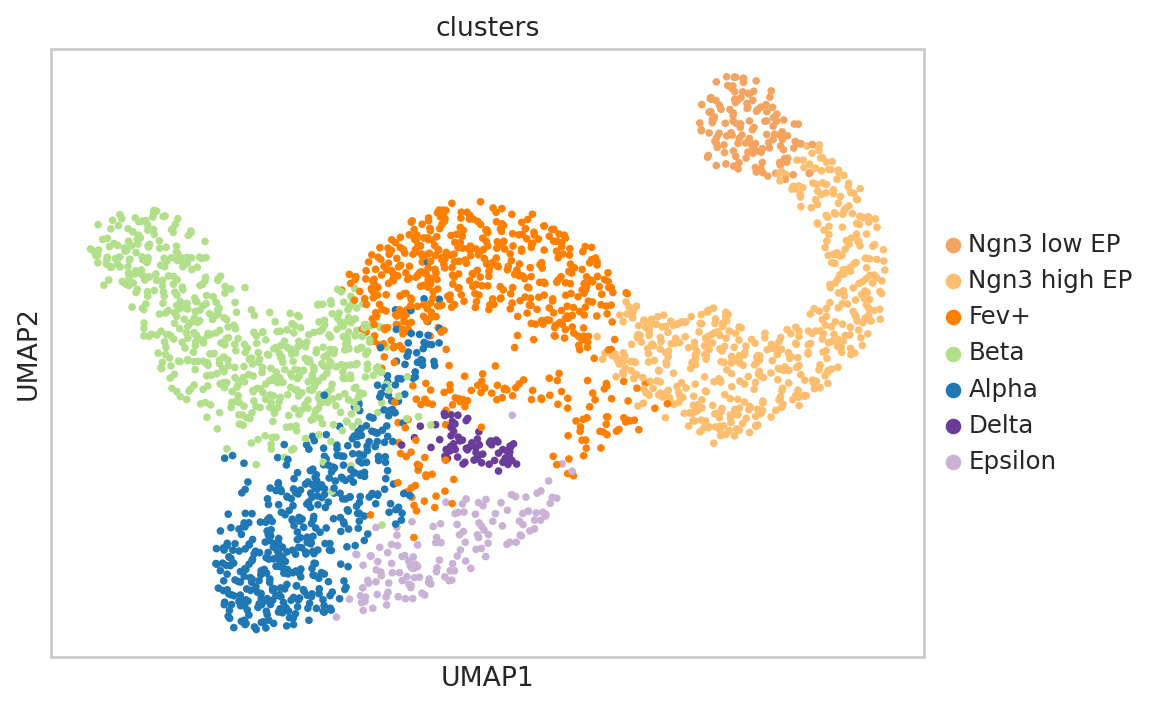

In [4]:
sc.pl.umap(adata, color="clusters")

Проведем стандартный препроцессинг

In [5]:
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, subset=True, layer="counts", flavor="seurat_v3")

In [6]:
sc.pp.pca(adata)

С помощью Palantir построим knn-граф в пространстве компонет диффузии

In [ ]:
sce.tl.palantir(adata, n_components=5, knn=30)

Determing nearest neighbor graph...


In [ ]:
adata

AnnData object with n_obs × n_vars = 2531 × 1500
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'counts'
    obsp: 'connectivities', 'distances'

Отрисуем diffusion map по первым двум компонентам

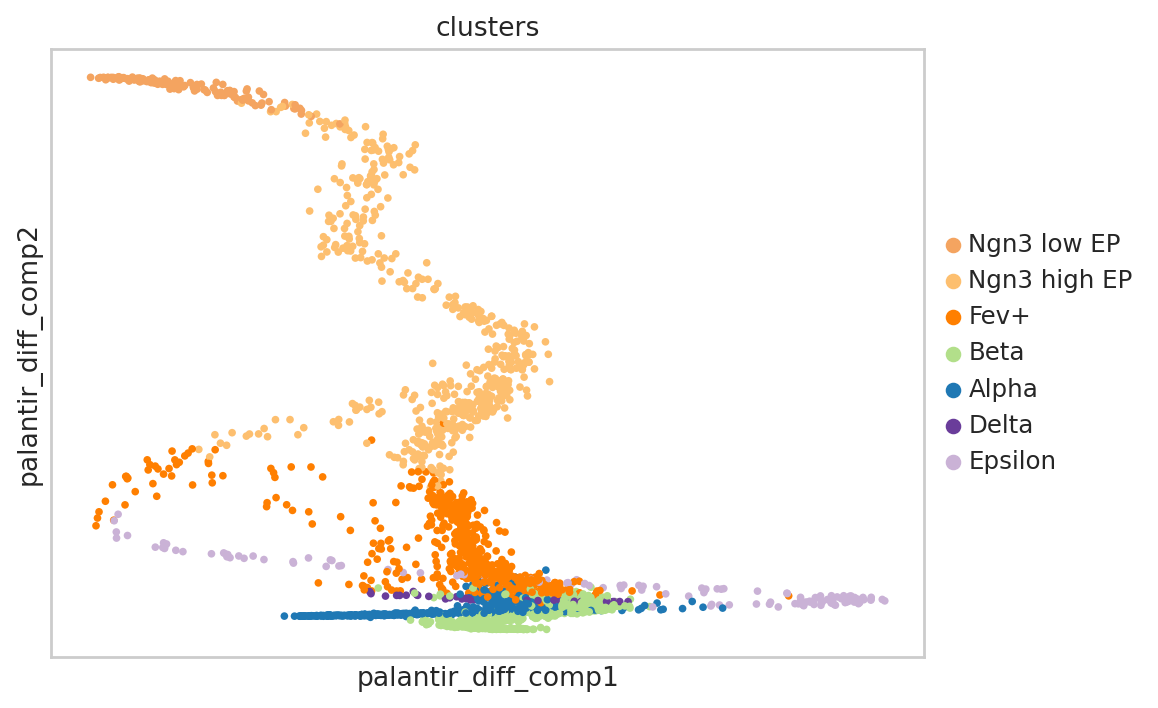

In [ ]:
sc.pl.embedding(adata, basis="palantir_diff_comp", color="clusters")

Отрисуем сами комопненты на нашем UMAP

In [ ]:
adata.obs["DC1"] = adata.obsm["X_palantir_diff_comp"][:,0]
adata.obs["DC2"] = adata.obsm["X_palantir_diff_comp"][:,1]
adata.obs["DC3"] = adata.obsm["X_palantir_diff_comp"][:,2]

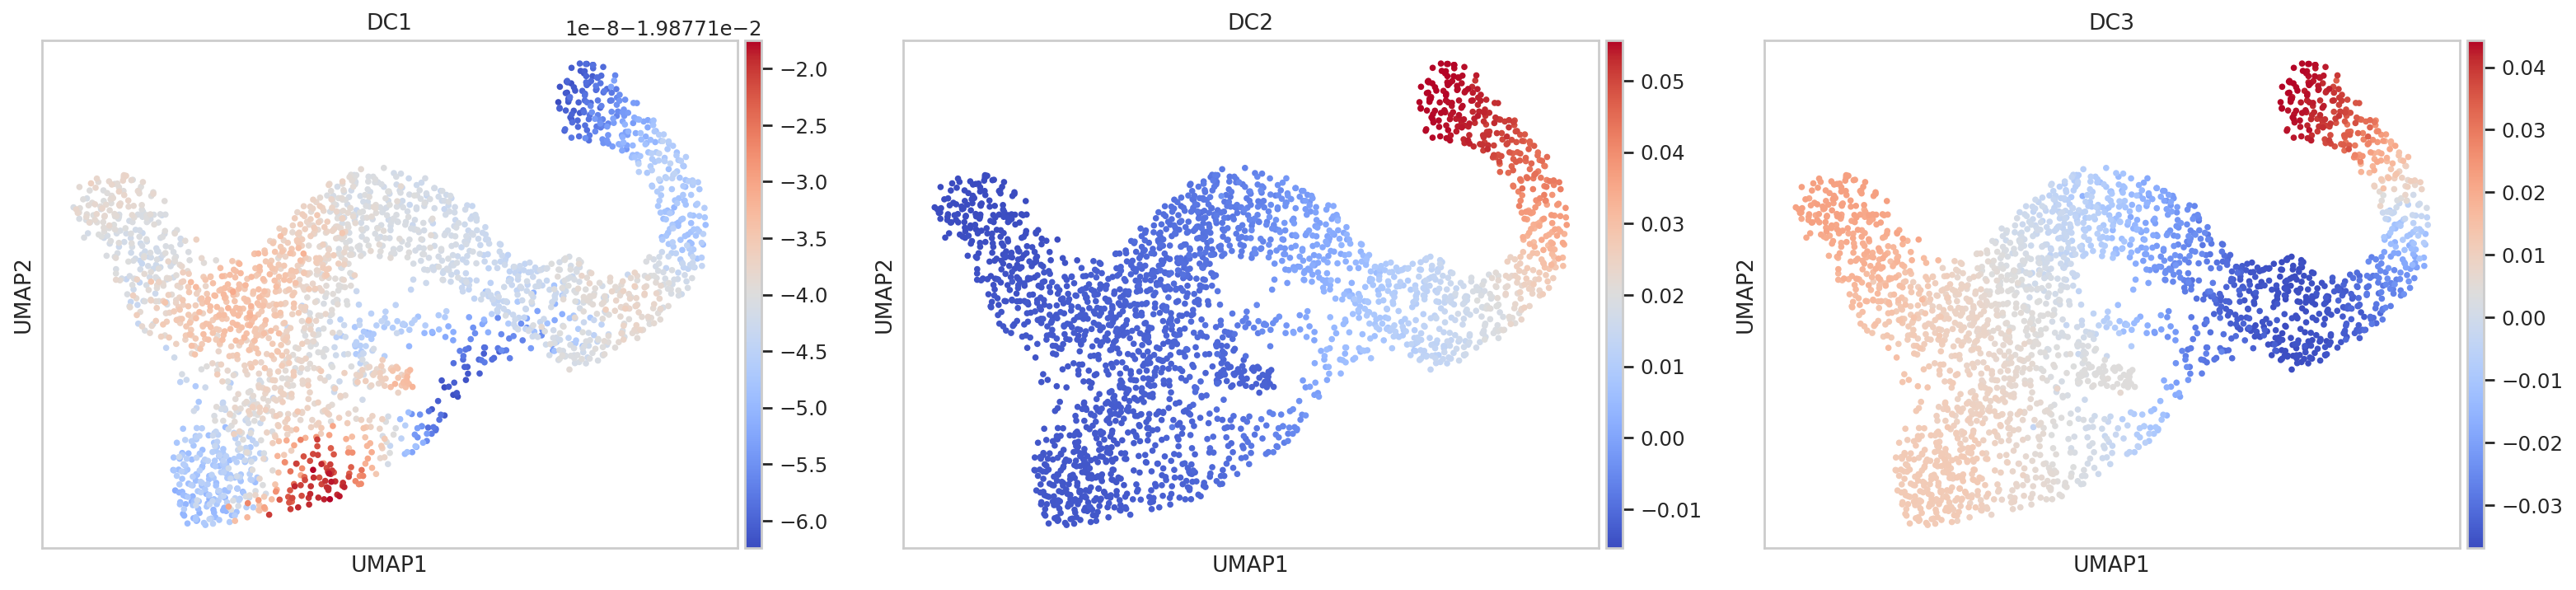

In [ ]:
sc.pl.umap(adata, color=["DC1","DC2","DC3"], cmap="coolwarm")

Построим t-SNE по первым двум компонентам диффузии

In [ ]:
sc.tl.tsne(adata, n_pcs=2, use_rep='X_palantir_multiscale', perplexity=90)

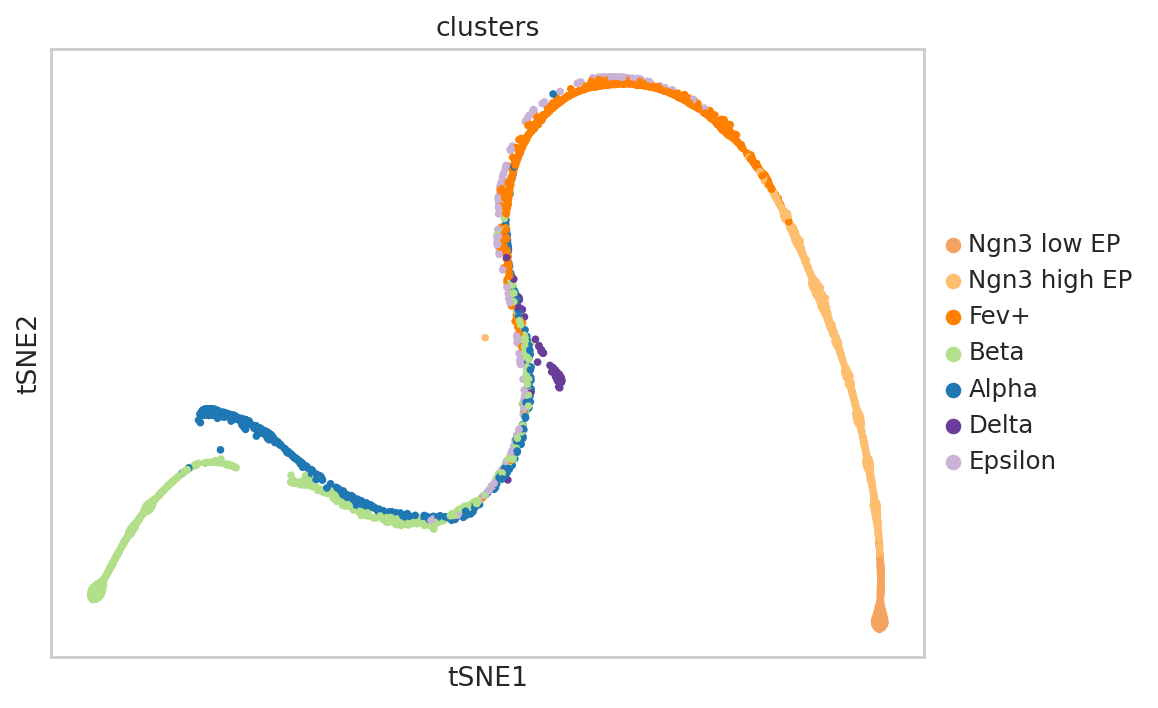

In [ ]:
sc.pl.tsne(adata, color="clusters")

Для оценки differentiation potential с помощью Palantir надо указать начальную и терминальные клетки. Попробуем подобрать их "на глаз" по нашим t-SNE и UMAP

In [ ]:
cluster_dict = {"Root": adata.obs["clusters"] == "Ngn3 low EP",
                "Alpha": adata.obs["clusters"] == "Alpha",
                "Beta": adata.obs["clusters"] == "Beta",
                "Delta": adata.obs["clusters"] == "Delta",
                "Epsilon": adata.obs["clusters"] == "Epsilon"}

In [ ]:
root_cell = adata.obs.index[cluster_dict["Root"]][0]
alpha_cell = adata.obs.index[cluster_dict["Alpha"]][15]
beta_cell = adata.obs.index[cluster_dict["Beta"]][10]
delta_cell = adata.obs.index[cluster_dict["Delta"]][15]
epsilon_cell = adata.obs.index[cluster_dict["Epsilon"]][0]

In [ ]:
root_cell

'AAACGGGTCAGCTCTC-1-3'

In [ ]:
cluster_cells = {"Root": adata.obs.index==root_cell,
                "Alpha": adata.obs.index==alpha_cell,
                "Beta": adata.obs.index==beta_cell,
                "Delta": adata.obs.index==delta_cell,
                "Epsilon": adata.obs.index==epsilon_cell}

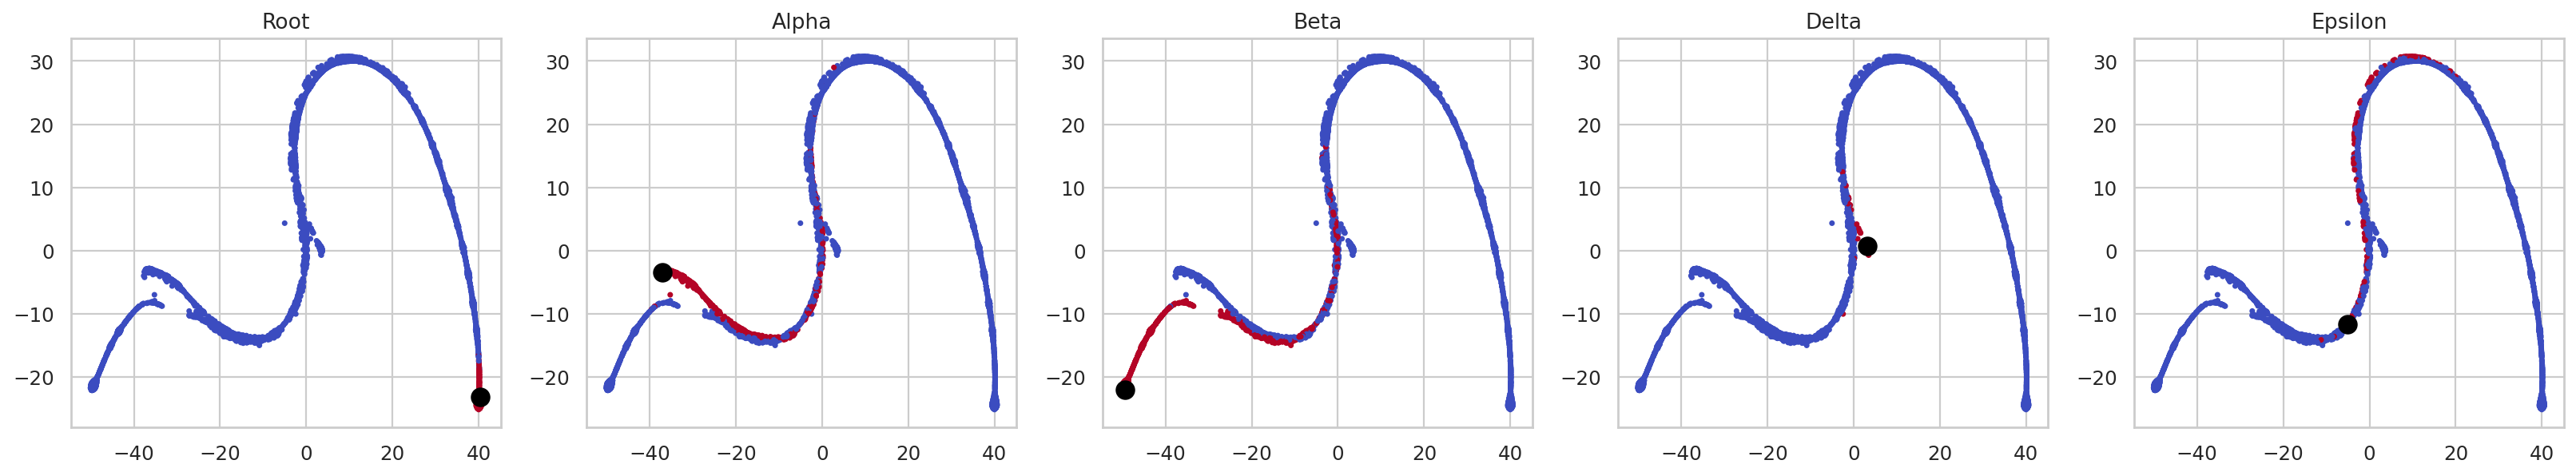

In [ ]:
fig,axs = plt.subplots(1,5,figsize=(25,4))
for i, ax in enumerate(fig.axes):
  cur_cluster = list(cluster_dict.keys())[i]
  sns.scatterplot(adata.obsm["X_tsne"][:,0], adata.obsm["X_tsne"][:,1], c=cluster_dict[cur_cluster], ax=ax, cmap="coolwarm", linewidth=0, s=10)
  ax.scatter(adata.obsm["X_tsne"][:,0][cluster_cells[cur_cluster]],
             adata.obsm["X_tsne"][:,1][cluster_cells[cur_cluster]], c="black", s=100)
  ax.set_title(cur_cluster)

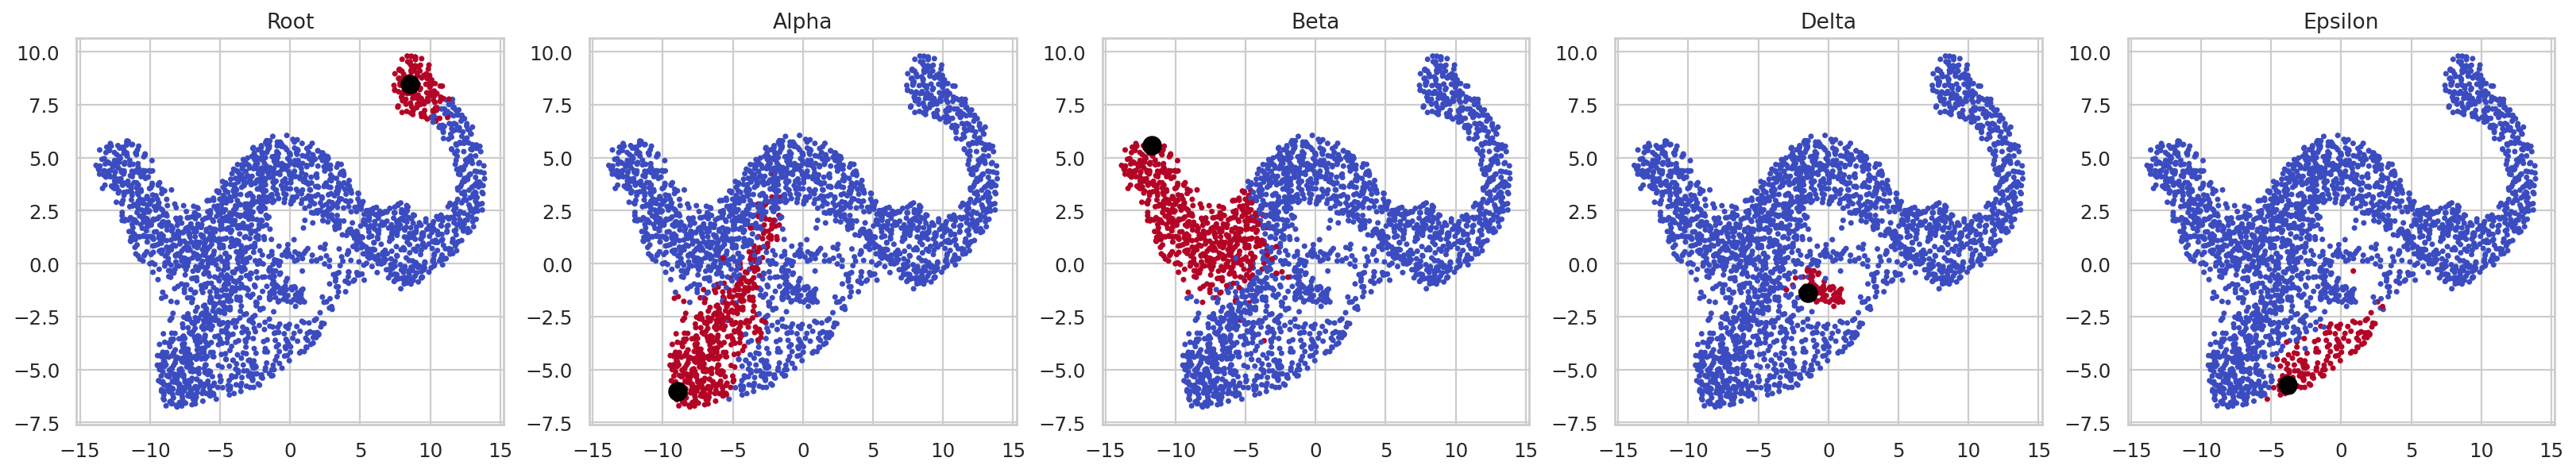

In [ ]:
fig,axs = plt.subplots(1,5,figsize=(25,4))
for i, ax in enumerate(fig.axes):
  cur_cluster = list(cluster_dict.keys())[i]
  sns.scatterplot(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1], c=cluster_dict[cur_cluster], ax=ax, cmap="coolwarm", linewidth=0, s=10)
  ax.scatter(adata.obsm["X_umap"][:,0][cluster_cells[cur_cluster]],
             adata.obsm["X_umap"][:,1][cluster_cells[cur_cluster]], c="black", s=100)
  ax.set_title(cur_cluster)

Запустим Palantir

In [ ]:
terminal_states = pd.Series(['Alpha', 'Beta', 'Delta', 'Epsilon'], 
                           index=[alpha_cell, beta_cell, delta_cell, epsilon_cell])

In [ ]:
pr_res = sce.tl.palantir_results(
    adata,
    early_cell=root_cell,
    ms_data='X_palantir_multiscale',
    num_waypoints=500,
    terminal_states = terminal_states.index,
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.004512103398640951 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.11834481159845987 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Отрисуем полученные оценки для вероятностей дифференцировки в разные терминальные состояния, а также для differentiation potential

In [ ]:
vars(pr_res).keys()

dict_keys(['_pseudotime', '_entropy', '_branch_probs', '_waypoints'])

In [ ]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

In [ ]:
adata.obs["pr_entropy"] = pr_res.entropy
adata.obs["pr_epsilon"] = pr_res.branch_probs["Epsilon"]
adata.obs["pr_beta"] = pr_res.branch_probs["Beta"]
adata.obs["pr_alpha"] = pr_res.branch_probs["Alpha"]
adata.obs["pr_delta"] = pr_res.branch_probs["Delta"]

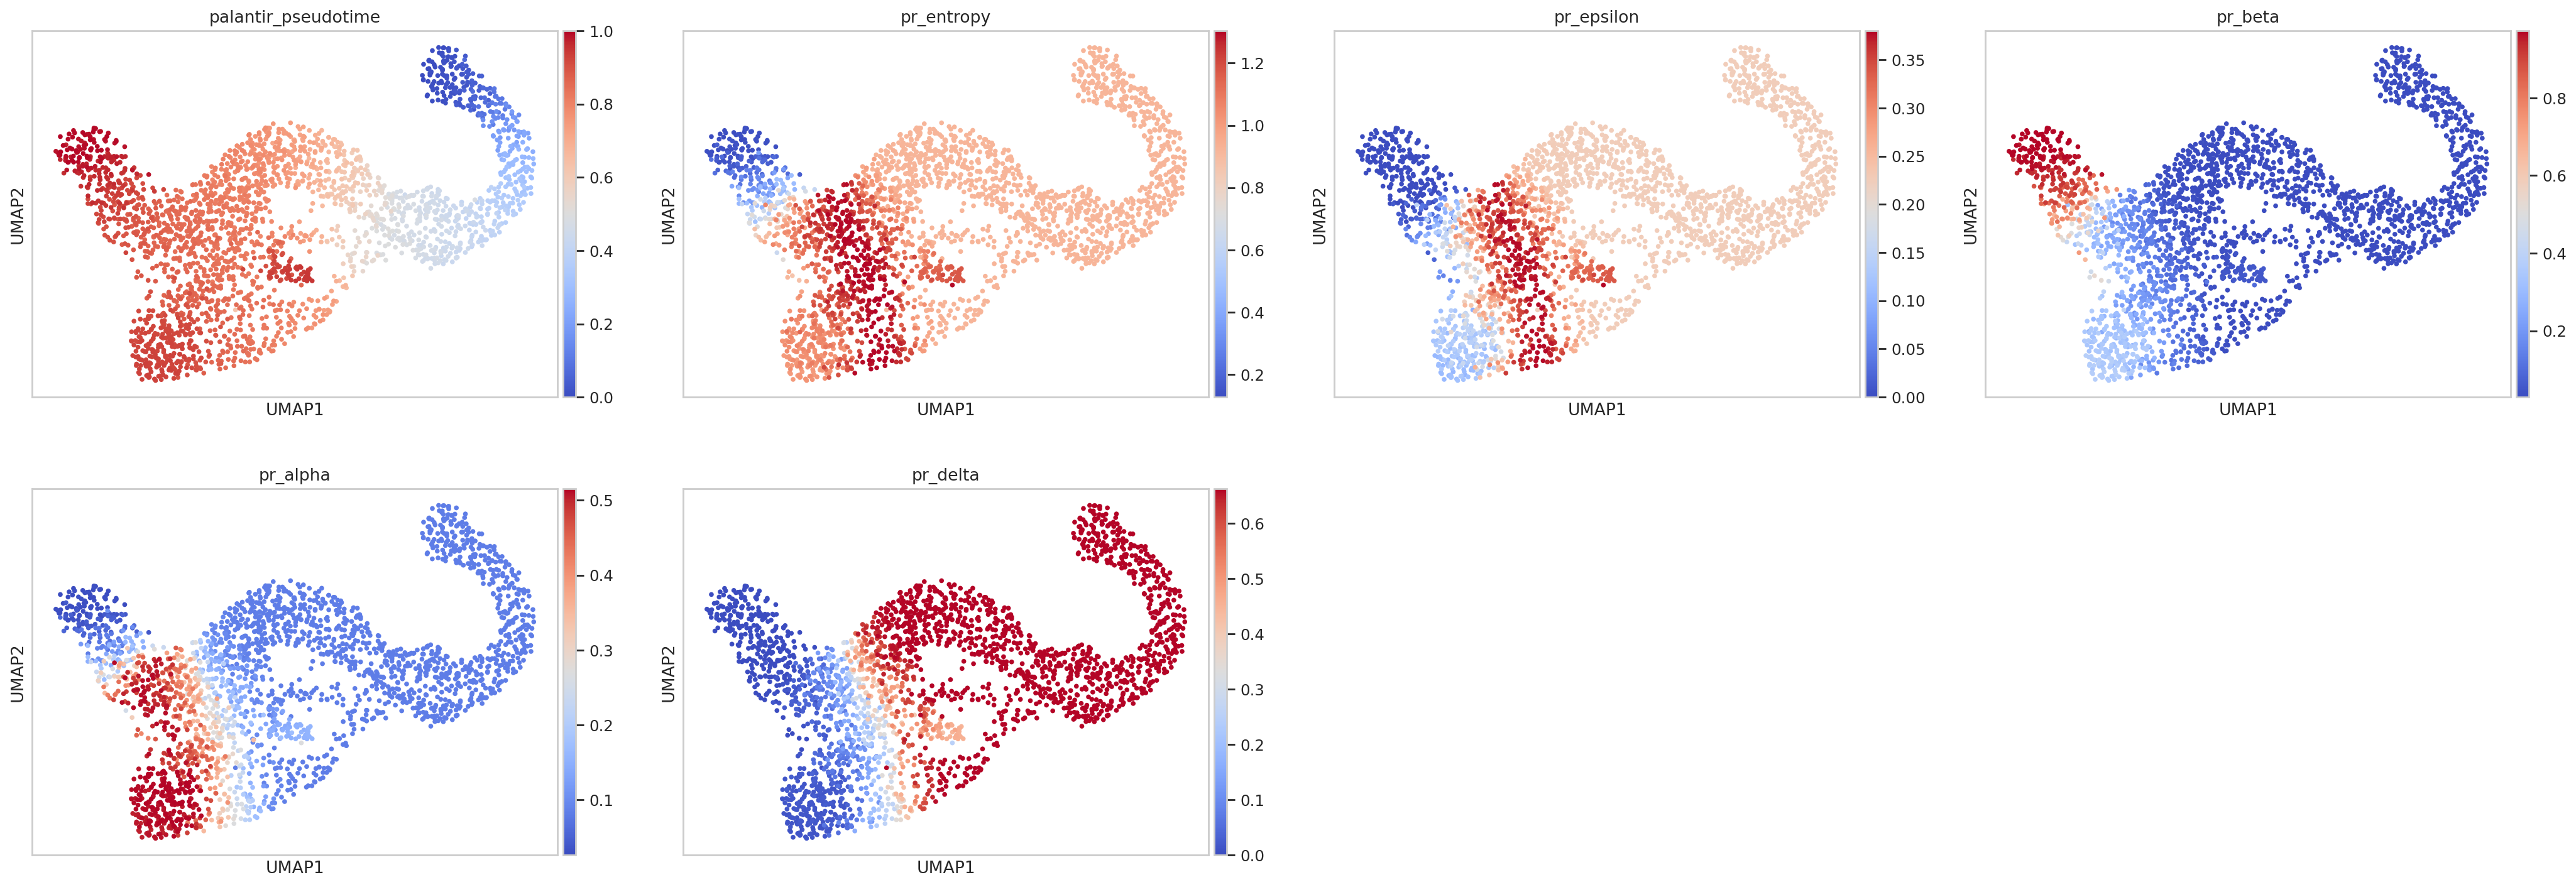

In [ ]:
sc.pl.umap(adata, color=["palantir_pseudotime", "pr_entropy", "pr_epsilon", "pr_beta", "pr_alpha", "pr_delta"], cmap="coolwarm")

## RNA velocity with scVelo

Теперь применим RNA velocity. Сначала посмотрим, сколько unspliced каунтов есть в наших данных.

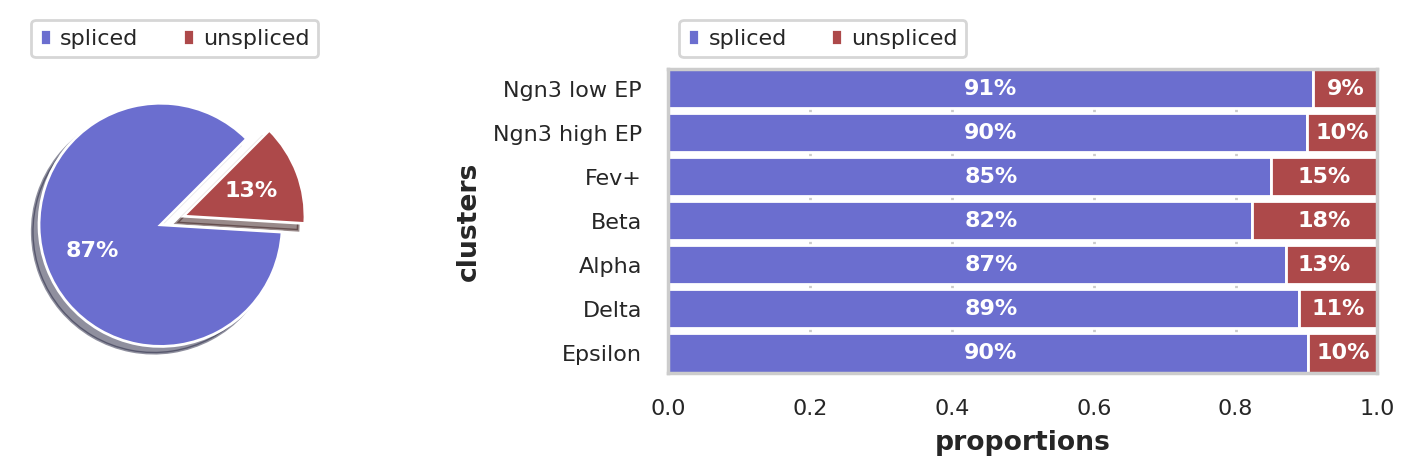

In [ ]:
scv.pl.proportions(adata)

Теперь мы можем оценить усредненные по ближайшим соседям средние и дисперсию spliced и unspliced counts:

In [ ]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Вычислим transcription, splicing и degradation rates для каждого гена, а также латентное время и transcriptional state каждой клетки:

In [ ]:
scv.tl.recover_dynamics(adata, n_jobs=-1) # ~5 minutes

recovering dynamics (using 2/2 cores)


  0%|          | 0/762 [00:00<?, ?gene/s]

    finished (0:05:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Получим оценки для RNA velocity и их графовое представление:

In [ ]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Получим общее по всем генам латентное время для каждой клетки:

In [ ]:
scv.tl.latent_time(adata)

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


Визуализируем RNA velocity. За что отвечают параметры smooth и min_mass? Попробуйте их изменить.

In [ ]:
scv.settings.set_figure_params("scvelo")

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


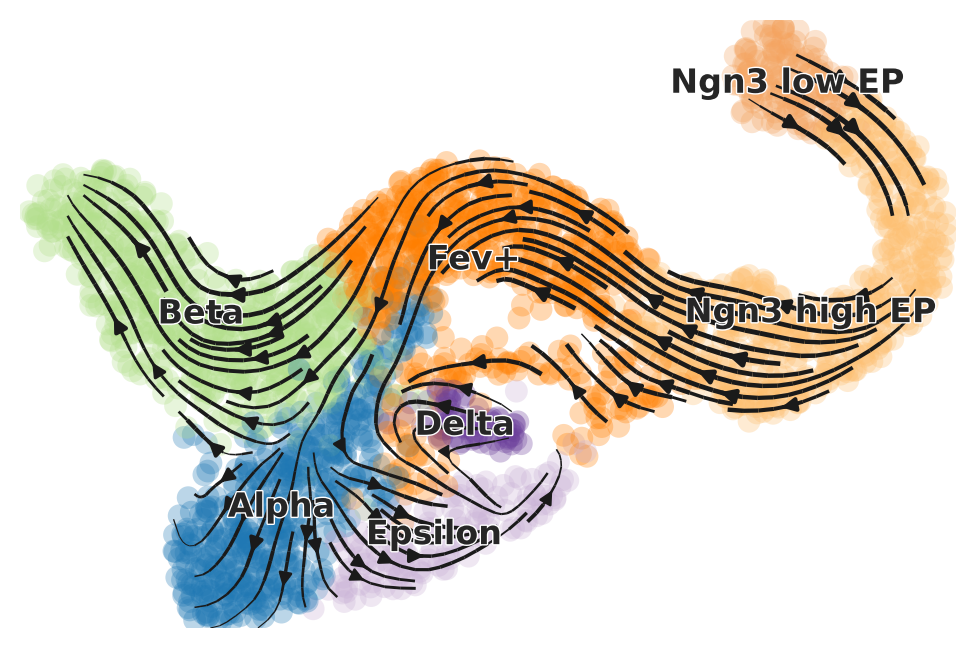

In [ ]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=12, title="", smooth=0.4, min_mass=4
)

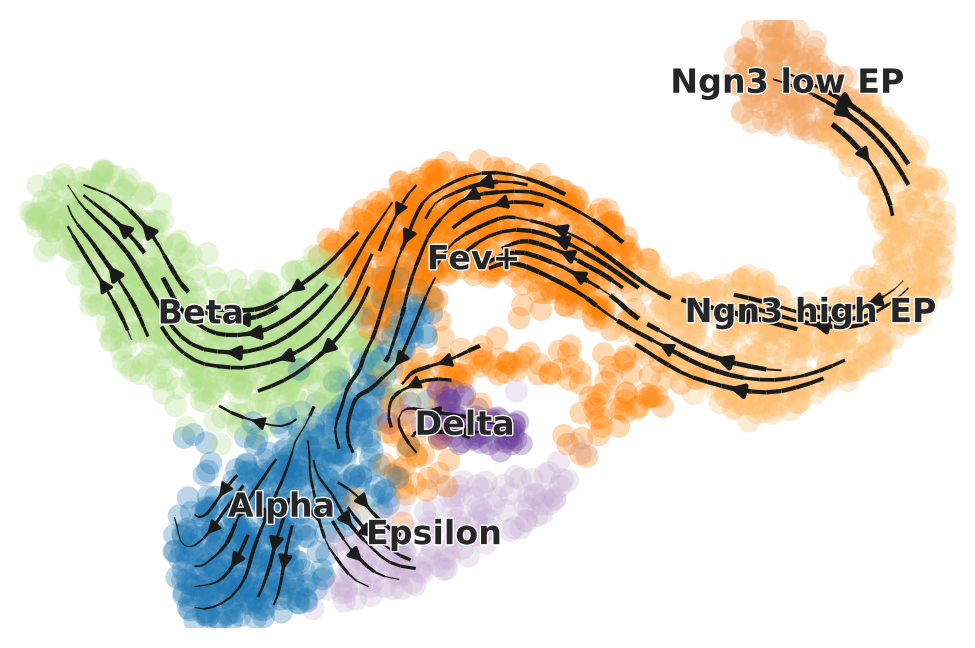

In [ ]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=12, title="", smooth=0.2, min_mass=4
)

In [ ]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=12, title="", smooth=0.4, min_mass=4, color="latent_time"
)

## Fate mapping with CellRank

Теперь на этом же датасете запустим CellRank:

In [ ]:
from cellrank.tl.estimators import GPCCA
kernel = cr.tl.transition_matrix(adata, weight_connectivities=0.2, n_jobs=-1, mode='monte_carlo') # ~6 minutes
g = GPCCA(kernel)
g.compute_schur(n_components=20)
g.compute_macrostates(cluster_key="clusters", n_states=12)

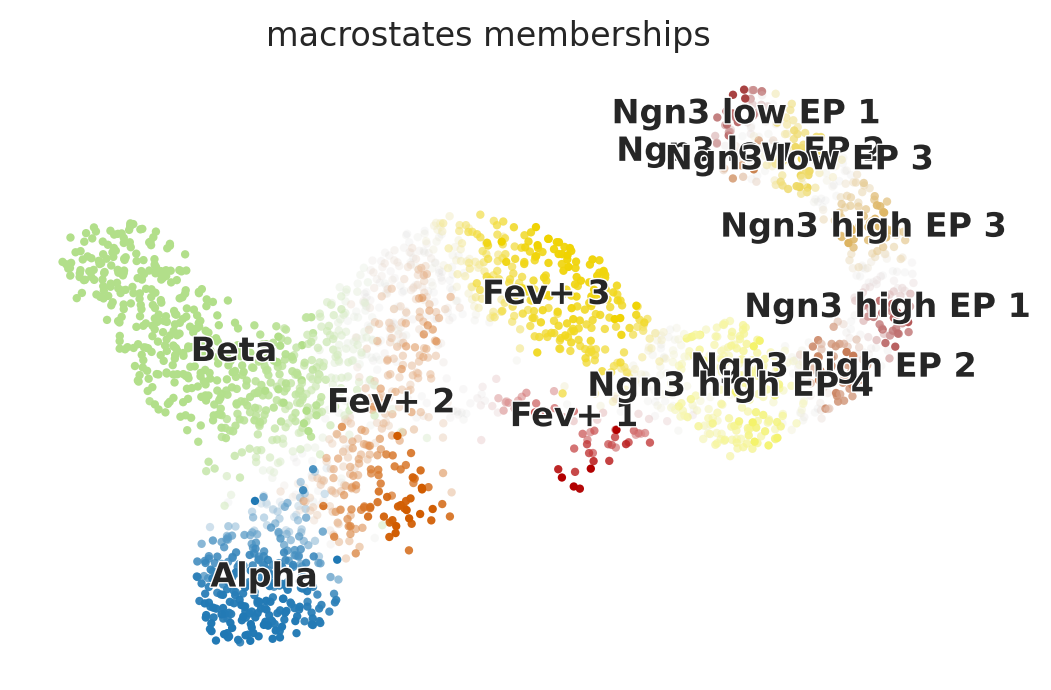

In [ ]:
g.plot_macrostates(same_plot=True)

Какие макросостояния соответствуют терминально дифференцированным клеткам?

Укажите их списком, чтобы назначить их терминальными и вычислить absorption probabilities:

In [ ]:
g.set_terminal_states_from_macrostates(names=???)
g.compute_absorption_probabilities()

Визуализируем absorption probabilities: цвет клетки соответствует терминальному состоянию, вероятность прихода к которому максимальна, а интенсивность цвета - значению этой вероятности.

In [ ]:
cr.pl.lineages(adata)

Теперь воспользуемся другим рассмотренным на лекции методом - PAGA (partition-based graph abstraction).

In [ ]:
scv.tl.paga(
    adata,
    groups="clusters",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="velocity_pseudotime",
)

In [ ]:
cr.pl.cluster_fates(
    adata,
    mode="paga_pie",
    cluster_key="clusters",
    basis="umap",
    legend_kwargs={"loc": "top right out"},
    legend_loc="top left out",
    node_size_scale=5,
    edge_width_scale=1,
    max_edge_width=4,
    title="directed PAGA",
)

Посчитаем корреляции экспрессии генов с вероятностью дифференцировки в разные терминальные макростояния:

In [ ]:
cr.tl.lineage_drivers(adata)

Визуализируем на UMAP экспрессию топ-5 генов, скоррелированных с вероятностью дифференцировки клеток в макросостояние Альфа:

In [ ]:
cr.pl.lineage_drivers(adata, lineage="Alpha", n_genes=5)

Датафрейм, который мы напечатали выше, теперь лежит в `adata.varm['terminal_lineage_drivers']`. Выведите топ 100 генов, скоррелированных с дифференцировкой в макросостояние Бета:

Визуализируйте изменение экспрессии нескольких из этих генов с ходом псевдовремени с помощью GAM:

In [ ]:
warnings.simplefilter("ignore", category=DeprecationWarning)
cr_gam = cr.ul.models.GAM(adata)
cr.pl.gene_trends(
    adata,
    model=cr_gam,
    data_key="X",
    genes=[???],
    ncols=3,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 4),
    n_test_points=200,
)

## Реализация алгоритма определения генов, меняющих свою экспрессию с ходом псевдовремени

CellRank позволяет сопоставить экспрессию генов с подсчитанными им вероятностями разных путей дифференцировки, но интересно может быть просто получить список генов, меняющих свою экспрессию с ходом псевдовремени вдоль какой-то из траекторий развития.

На лекции мы обсудили, что для этой цели подходят генерализованные аддитивные модели (GAM). Их можно строить либо с помощью пакета mgcv для R, либо с помощью питоновской библиотеки pyGAM. Мы воспользуемся первым способом, поскольку это позволит нам удобным образом делать F-тест для сравнения двух моделей: $g_i \sim t_i$ и  $g_i \sim 1$. Так мы сможем выделить гены, чья экспрессия значимо меняется.

Мы воспользуемся готовым F-тестом для моделей, но его можно реализовать и самостоятельно. Это может пригодиться, например, в более сложных случаях, когда вы оцениваете значимость изменений экспрессии гена сразу на нескольких траекториях, обучая модели с разным числом степеней свободы.

Присвоим переменной `ngn3_trajectory` сабсет нашей `adata` - клетки, относящиеся к кластерам "Ngn3 low EP" и "Ngn3 high EP":

In [ ]:
ngn3_trajectory = adata[adata.obs["clusters"].isin(["Ngn3 low EP", "Ngn3 high EP"])]

Визуализируйте `ngn3_trajectory` с помощью UMAP, покрасив его по `palantir_pseudotime`:

In [ ]:
#your code

Давайте подготовим несколько переменных для экспорта в R и проверим, что всё прошло успешно:

In [ ]:
ngn3_genes = ngn3_trajectory.X.A
pseudotime = ngn3_trajectory.obs["palantir_pseudotime"]
ngn3_genenames = ngn3_trajectory.var.index
clusters = ngn3_trajectory.obs["clusters"]

In [ ]:
%%R -i ngn3_genes,pseudotime,ngn3_genenames,clusters

print(pseudotime[1:5])
print(ngn3_genes[1:4,1:4])
print(ngn3_genenames[1:5])
print(clusters[1:5])

Давайте для начала протестируем какой-нибудь один ген. Заполните пропуски в формуле:

In [ ]:
%%R
library(mgcv)

model_time <- gam(???~s(???,k=5),data=data.frame("gene"=ngn3_genes[,1],"t"=pseudotime))
model_const <- gam(???~???,data=data.frame("gene"=ngn3_genes[,1],"t"=pseudotime))

#perform overrided anova for S3 class gam
as.list(anova(model_time, model_const, test="F"))
anova(model_time, model_const, test="F")

Воспользуемся функциями семейство `a-ply` из `plyr`, чтобы протестировать сразу все гены. В один список мы сохраним сами модели, чтобы можно было потом отрисовывать их предсказания, а в другой - p-value F-теста для этих моделей:

In [ ]:
%%R -o gam_signif
library(plyr)

gam_time <- alply(ngn3_genes, 2, function(gene,pseudotime) {
    gam(???~s(???,k=5), data=data.frame("gene"=gene,"t"=pseudotime))
},pseudotime)

gam_signif <- aaply(ngn3_genes, 2, function(gene,pseudotime) {
    model_time <- gam(???~s(???,k=5), data=data.frame("gene"=gene,"t"=pseudotime))
    model_const <- gam(???~???, data=data.frame("gene"=gene))
    #perform overrided anova for S3 class gam
    anova(model_time, model_const, test='F')$`Pr(>F)`[2]
},pseudotime)
gam_signif <- p.adjust(gam_signif, method = "bonferroni")

names(gam_time) <- ngn3_genenames
names(gam_signif) <- ngn3_genenames

Выведите 10 наиболее значимых генов:

In [ ]:
%%R

#your_code

Создадим датафрейм с информацией об экспрессии генов, а также с предсказаниями модели для одного из генов, полученных выше:

In [ ]:
%%R
library(tidymv)

genes_df <- as.data.frame(ngn3_genes)
colnames(genes_df) <- ngn3_genenames
genes_df["pseudotime"] <- pseudotime
genes_df["clusters"] <- clusters

gene <- ???

model_pred <- predict_gam(gam_time[gene][[1]])

Посмотрите с помощью `head()`, как выглядит датафрейм `model_pred` и визуализируйте предсказания GAM и экспрессию для наиболее значимых генов:

In [ ]:
%%R

#your code

In [ ]:
%%R
library(ggplot2)
library(dplyr)

ggplot(model_pred, aes(???, ???)) +
  geom_smooth_ci(color="blue") +
  geom_point(aes_string("pseudotime",gene,color="clusters"),data=genes_df)

Отрисуйте экспрессию этих генов на UMAP:

In [ ]:
#your code

## Домашнее задание

Palantir смог хорошо идентифицировать как терминальное состояние, из которого клетки уже не могут перейти в другие типы, только бета-клетки.

Попробуйте исключить из `adata` кластеры, соответствующие дельта- и эпсилон-клеткам, и запустить Palantir еще раз, теперь уже с двумя терминальными состояниями: альфа и бета. Как изменилась оценка энтропии для клеток? Какие выводы можно из этого сделать?

In [7]:
adata

AnnData object with n_obs × n_vars = 2531 × 1500
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
adata_for_hw = adata[(adata.obs["clusters"]!="Delta")&(adata.obs["clusters"]!="Epsilon")]

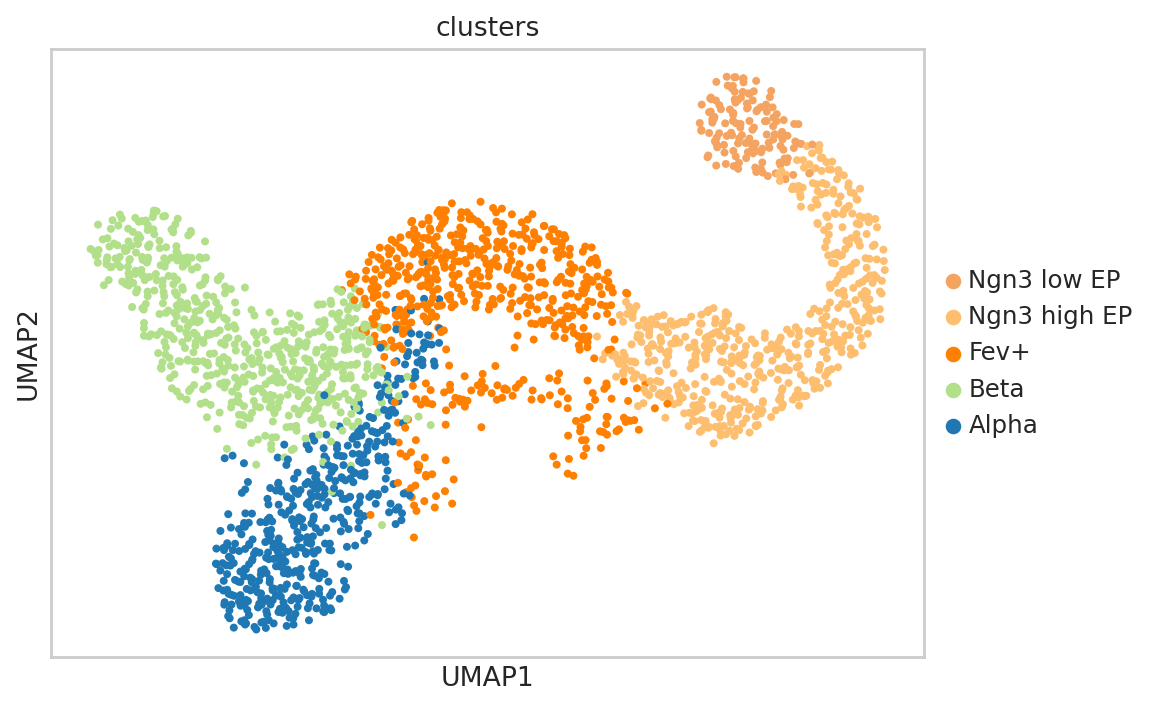

In [9]:
sc.pl.umap(adata_for_hw, color = "clusters")

In [10]:
sce.tl.palantir(adata_for_hw, n_components=5, knn=30)

Determing nearest neighbor graph...


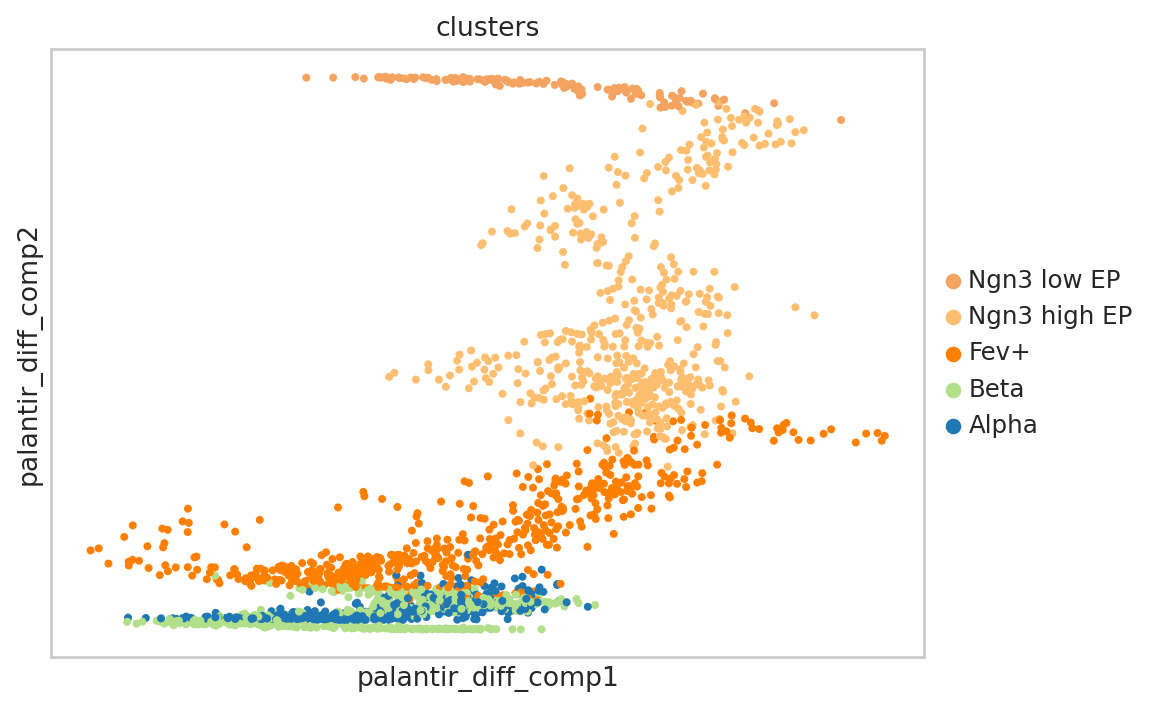

In [11]:
sc.pl.embedding(adata_for_hw, basis="palantir_diff_comp", color="clusters")

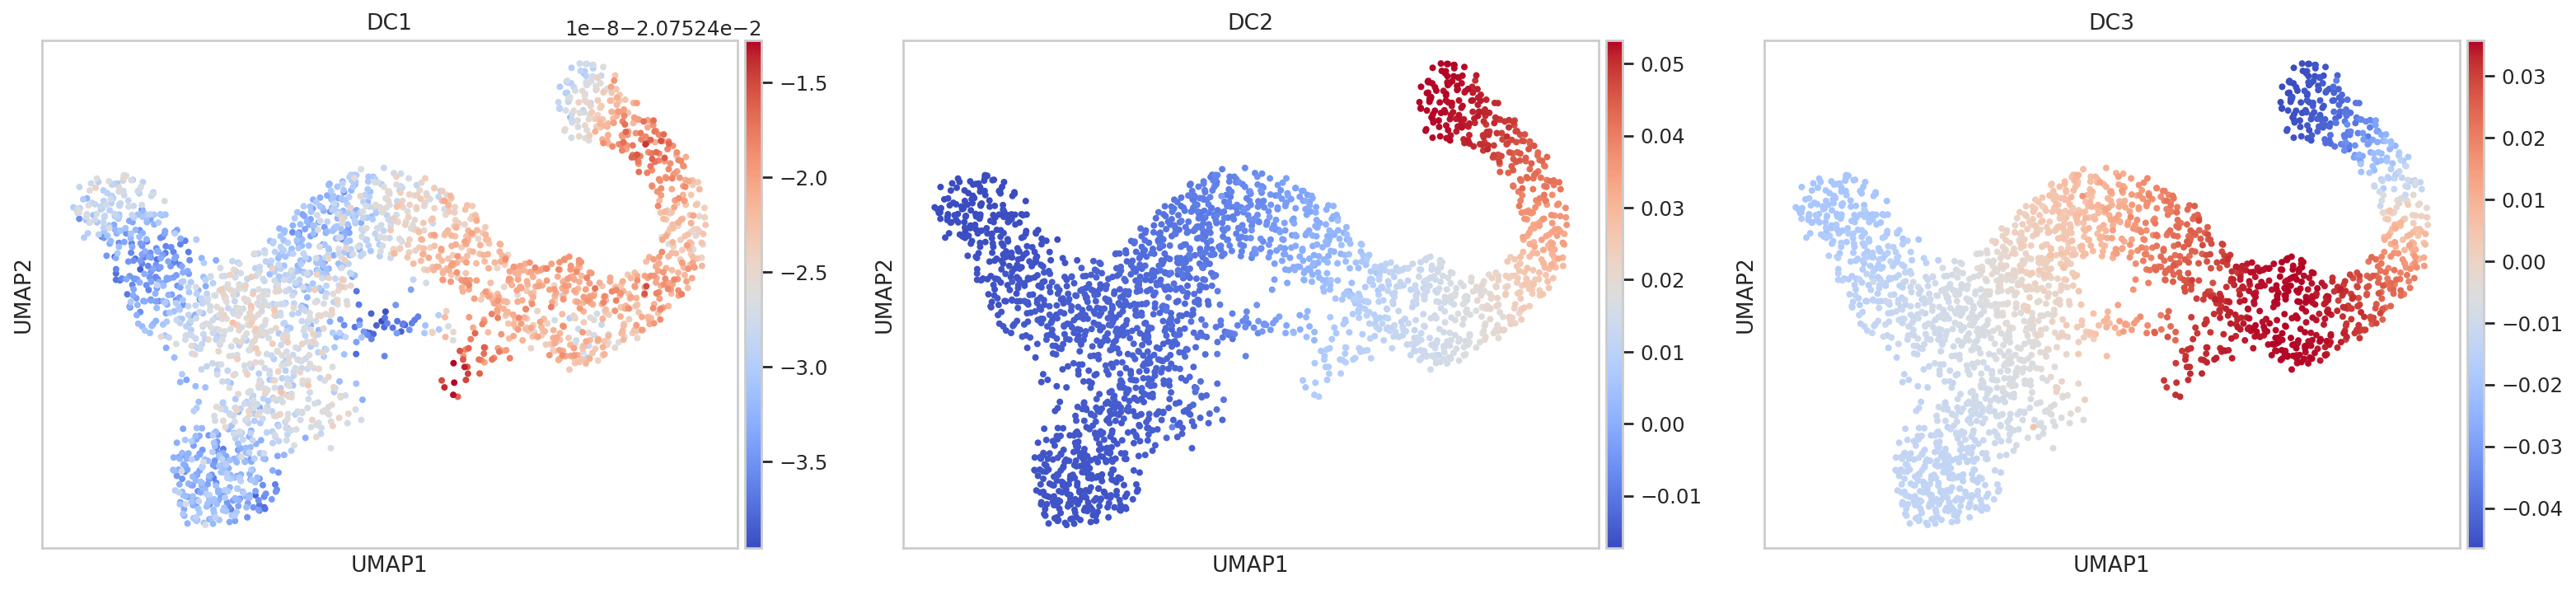

In [12]:
adata_for_hw.obs["DC1"] = adata_for_hw.obsm["X_palantir_diff_comp"][:,0]
adata_for_hw.obs["DC2"] = adata_for_hw.obsm["X_palantir_diff_comp"][:,1]
adata_for_hw.obs["DC3"] = adata_for_hw.obsm["X_palantir_diff_comp"][:,2]
sc.pl.umap(adata_for_hw, color=["DC1","DC2","DC3"], cmap="coolwarm")

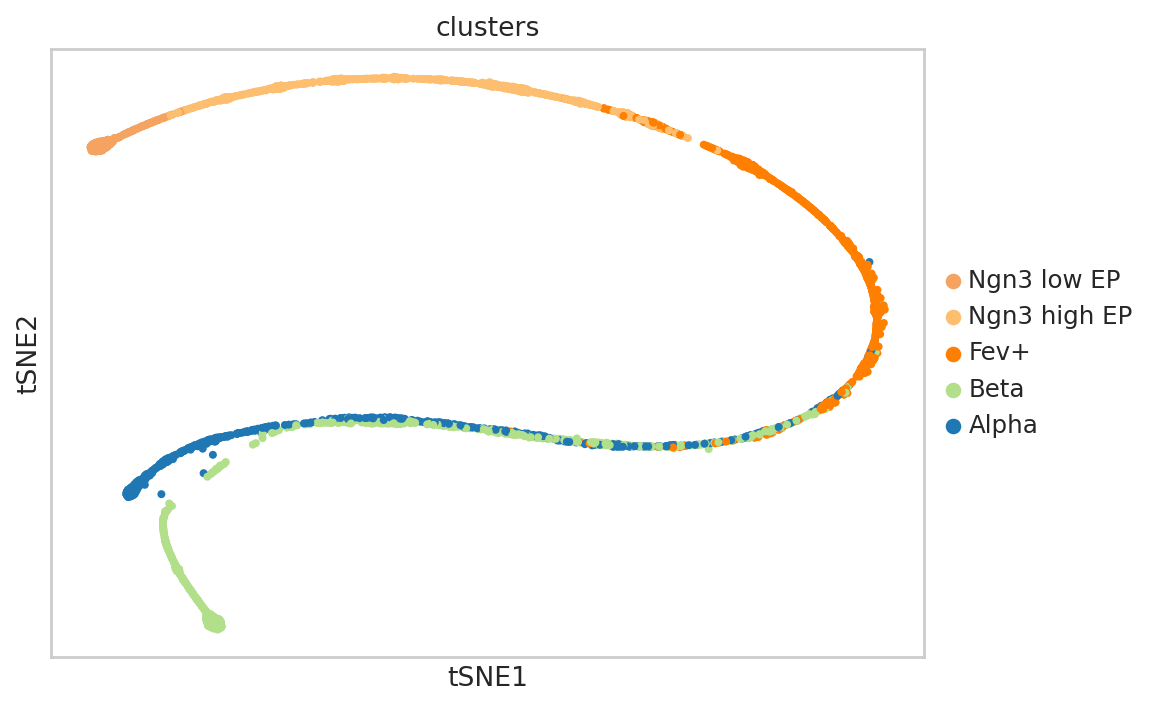

In [13]:
sc.tl.tsne(adata_for_hw, n_pcs=2, use_rep='X_palantir_multiscale', perplexity=90)
sc.pl.tsne(adata_for_hw, color="clusters")

При запуске Palantir мы выбирали терминальные клетки "на глаз". Попробуем сделать это, воспользовавшись результатами CellRank.

Для этого с помощью результатов работы CellRank выделите гены, высоко скоррелированные с дифференцировкой только эпсилон-клеток, но не других типов клеток.

Подсказка: выберите кажущиеся вам разумными пороги по корреляции экспрессии генов с вероятностью дифференцировки в Эпсилон-макросостояние и в другие состояния, отфильтруйте по этим значениям строки датафрейма `adata.varm['terminal_lineage_drivers']`. Добейтесь того, чтобы получить от нескольких штук до нескольких десятков генов.

In [ ]:
scv.pl.proportions(adata)

In [ ]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
scv.tl.recover_dynamics(adata, n_jobs=-1) # ~5 minutes
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)

In [ ]:
scv.settings.set_figure_params("scvelo")

In [ ]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=12, title="", smooth=0.4, min_mass=4
)

In [ ]:
from cellrank.tl.estimators import GPCCA
kernel = cr.tl.transition_matrix(adata, weight_connectivities=0.2, n_jobs=-1, mode='monte_carlo') # ~6 minutes
g = GPCCA(kernel)
g.compute_schur(n_components=20)
g.compute_macrostates(cluster_key="clusters", n_states=12)


In [ ]:
g.set_terminal_states_from_macrostates(names=["Alpha","Beta","Epsilon_1","Epsilon_2"])
g.compute_absorption_probabilities()

In [ ]:
cr.tl.lineage_drivers(adata)

In [ ]:
corr_data = adata.varm['terminal_lineage_drivers']

In [ ]:
list(corr_data[(corr_data["Epsilon_1_corr"]>=0.45)&(corr_data["Alpha_corr"]<=0.1)&(corr_data["Beta_corr"]<=0.1)].index)

Отрисуйте экспрессию этих генов на UMAP

In [ ]:
sc.pl.umap(adata, color=['Arg1', 'Cdkn1a', 'Gm11837', 'Ghrl', 'Anpep', 'Mboat4', 'Irs4', 'Maged2'], cmap="viridis")

Получите индекс клетки, в которой общая экспрессия этих генов выше, чем в остальных. Отрисуйте эту клетку на UMAP и t-SNE аналогично тому, как мы делали это на семинаре для терминальных клеток Palantir.

Согласуется ли положение этой клетки:

*   с тем, как выглядит дифференцировка на t-SNE, потсроенном по полученным Palantir'ом компонентам диффузии?
*   с тем, какую оценку изменения экспрессии дал scVelo? (посмотрите на UMAP со спроецированными на него предсказаниями RNA velocity)

С учетом того, что для определения скоррелированных с дифференцировкой генов вы использовали CellRank, является это неожиданным или же закономерным?

Text(0.5, 1.0, 'Epsilon')

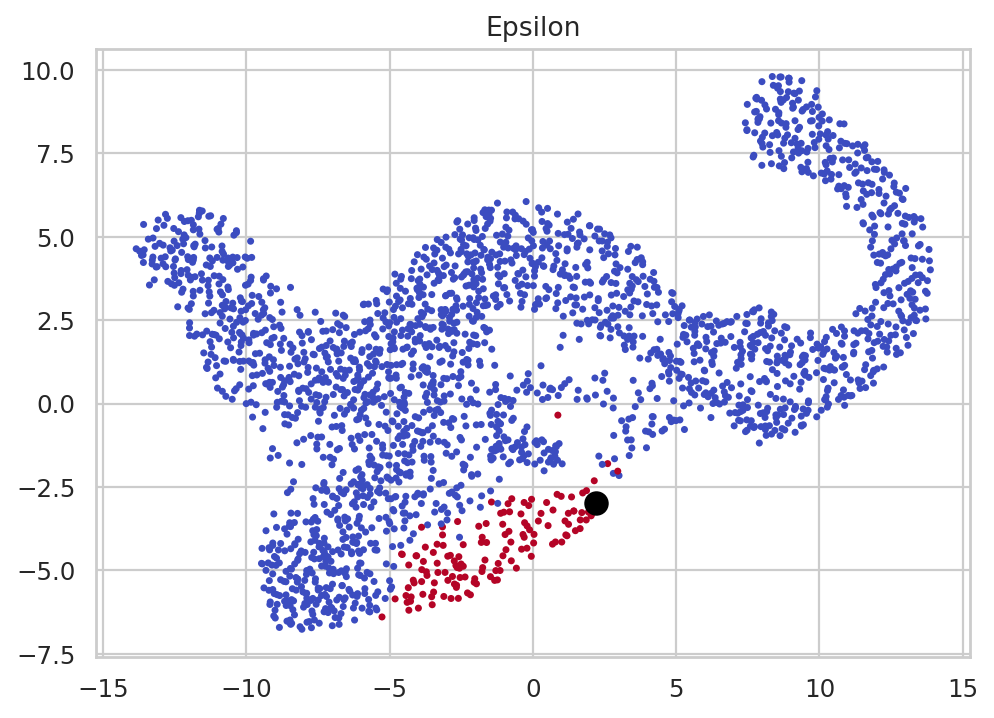

In [ ]:
#Определяем индекс клетки
adata_subset = adata[:,['Arg1', 'Cdkn1a', 'Gm11837', 'Ghrl', 'Anpep', 'Mboat4', 'Irs4', 'Maged2']]
target_cell = adata_subset[adata_subset.X.sum(axis=1).argmax()].obs.index


#Визуализируем
cluster_dict = {"Root": adata.obs["clusters"] == "Ngn3 low EP",
                "Alpha": adata.obs["clusters"] == "Alpha",
                "Beta": adata.obs["clusters"] == "Beta",
                "Delta": adata.obs["clusters"] == "Delta",
                "Epsilon": adata.obs["clusters"] == "Epsilon"}


sns.scatterplot(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1],c=cluster_dict["Epsilon"], cmap="coolwarm", linewidth=0, s=10)
plt.scatter(adata.obsm["X_umap"][:,0][adata.obs.index == target_cell[0]], adata.obsm["X_umap"][:,1][adata.obs.index == target_cell[0]], c="black", s=100)
plt.title("Epsilon")

Text(0.5, 1.0, 'Epsilon')

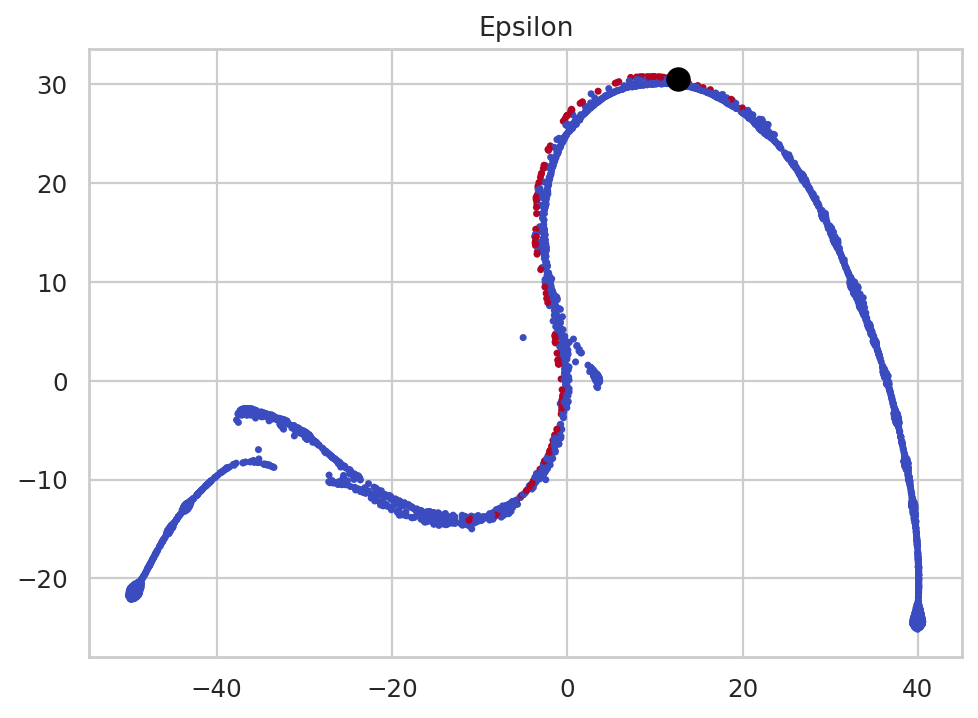

In [ ]:
sns.scatterplot(adata.obsm["X_tsne"][:,0], adata.obsm["X_tsne"][:,1],c=cluster_dict["Epsilon"], cmap="coolwarm", linewidth=0, s=10)
plt.scatter(adata.obsm["X_tsne"][:,0][adata.obs.index == target_cell[0]], adata.obsm["X_tsne"][:,1][adata.obs.index == target_cell[0]], c="black", s=100)
plt.title("Epsilon")

Полученная позиция клетки хорошо соотносится с положением кластера на t-SNE, построенном по компонентам диффузии, а также просто идеально ложится на результаты RNA velocity, т.к. в кластере Epsilon стрелочки ведут именно в ту точку, в которой находится наша выбранная клетка. Однако этот факт неудивителен, учитывая то, что мы запускали CellRank на основе RNA velocity. Стрелочки, ведущие в направлении увеличения экспрессии генов, характерных для кластера, сошлись в клетке, в которой суммарная экспрессия этих генов максимальна - всё логично.